## Import

In [1]:
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import os
from torch import optim
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from nmt.model import EncoderLSTM, DecoderLSTM, DotAttenDecoderLSTM
from nmt.train import train, trainIters
from nmt.infer import infer
from nmt.eval import eval
from nmt.utils import BatchGenerator

## Data Setup

In [3]:
MAX_LENGTH = 25

In [4]:
# set data path
data_dir = os.path.join('datasets', 'nmt_data_vi')
train_source = 'train.vi'
train_target = 'train.en'
train_source_dir = os.path.join(data_dir, train_source)
train_target_dir = os.path.join(data_dir, train_target)

test_source = 'tst2012.vi'
test_target = 'tst2012.en'
test_source_dir = os.path.join(data_dir, test_source)
test_target_dir = os.path.join(data_dir, test_target)

vocab_source = 'vocab.vi'
vocab_target = 'vocab.en'
vocab_source_dir = os.path.join(data_dir, vocab_source)
vocab_target_dir = os.path.join(data_dir, vocab_target)

In [5]:
# load training sets
with open(train_source_dir) as f_source:
    sentences_source = f_source.readlines()
with open(train_target_dir) as f_target:
    sentences_target = f_target.readlines()

# check the total number of sentencs in training sets    
print("Total number of sentences in source training set: {}".format(len(sentences_source)))
print("Total number of sentences in target training set: {}".format(len(sentences_target)))

# load testing sets
with open(test_source_dir) as f_source:
    test_source = f_source.readlines()
with open(test_target_dir) as f_target:
    test_target = f_target.readlines()

# check the total number of sentencs in training sets    
print("Total number of sentences in source testing set: {}".format(len(test_source)))
print("Total number of sentences in target testing set: {}".format(len(test_target)))

Total number of sentences in source training set: 133317
Total number of sentences in target training set: 133317
Total number of sentences in source testing set: 1553
Total number of sentences in target testing set: 1553


In [6]:
# check the longest sentence after sentence truncation
max = 0
for s in sentences_source:
    if len(s) > max:
        max = len(s)
        max_s = s
print("Number of words in the longest sentence in sentences_source: {}".format(max))
print("The longest sentence: \n{}".format(max_s))

Number of words in the longest sentence in sentences_source: 3199
The longest sentence: 
Thula Mama , Thula Mama , Thula Mama , Thula Mama . Trong kí ức tuổi thơ con , qua những giọt lệ nhoè mắt bà , con thấy chân lý trong nụ cười của bà , con thấy chân lý trong nụ cười của bà , xuyên thấu màn đêm u tối trong sự vô tri của con . Ôi , có một người bà đang nằm nghỉ bà ốm đau và trái tim bà rơi lệ . Băn khoăn , băn khoăn , băn khoăn , băn khoăn liệu thế giới này đang đi về đâu . Lẽ nào chuyện trẻ nhỏ phải tự xoay xở lấy là đúng ? Không , không , không , không , không , không . Lẽ nào phiền muộn dồn hết lên mái đầu người phụ nữ già là đúng ? Những người vô danh bất hạnh . Thula Mama Mama , Thula Mama . Thula Mama Mama . Thula Mama , Thula Mama , Thula Mama Mama , Thula Mama . Ngày mai sẽ tốt đẹp hơn . Ngày mai trèo đèo lội suối sẽ dễ hơn , bà ơi . Thula Mama , Thula Mama . Tôi có nên tan vào bài hát này như người đàn ông hát nhạc blues hay một người hát rong . Và rồi từ rất xa , không phải

In [7]:
# Truncate sentences by maximum length
sentences_source = list(map(lambda src:src.split()[:MAX_LENGTH], sentences_source))
sentences_target = list(map(lambda src:src.split()[:MAX_LENGTH], sentences_target))
test_source = list(map(lambda src:src.split()[:MAX_LENGTH], test_source))
test_target = list(map(lambda src:src.split()[:MAX_LENGTH], test_target))

In [8]:
# Delete empty sentences in source and target
i = 0
while i < len(sentences_source):
    if sentences_source[i]==[] or sentences_target[i]==[]:
        del sentences_source[i]
        del sentences_target[i]
        i -= 1
    i += 1
print(len(sentences_source))
print(len(sentences_target))

i = 0
while i < len(sentences_source):
    if sentences_source[i]==[] or sentences_target[i]==[]:
        del test_source[i]
        del test_target[i]
        i -= 1
    i += 1
print(len(test_source))
print(len(test_target))

133166
133166
1553
1553


In [9]:
# load vocabularies

# build index2word
with open(vocab_source_dir) as f_vocab_source:
    #index2word_source = f_vocab_source.readlines()
    index2word_source = [line.rstrip() for line in f_vocab_source]
with open(vocab_target_dir) as f_vocab_target:
    #index2word_target = f_vocab_target.readlines()
    index2word_target = [line.rstrip() for line in f_vocab_target]

# build word2index
word2index_source = {}
for idx, word in enumerate(index2word_source):
    word2index_source[word] = idx
word2index_target = {}
for idx, word in enumerate(index2word_target):
    word2index_target[word] = idx
    
# check vocabularies size    
source_vocab_size = len(index2word_source)
target_vocab_size = len(index2word_target)
print("Total nummber of words in source vocabulary: {}".format(len(index2word_source)))
print("Total nummber of words in target vocabulary: {}".format(len(index2word_target)))    

Total nummber of words in source vocabulary: 7709
Total nummber of words in target vocabulary: 17191


## Parameters Setup

In [10]:
# misc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# encoder & decoder init
input_size = source_vocab_size
output_size = target_vocab_size+1 # +1 is a wordaround for ignore_index field of NLLLoss
hidden_size = 512
dropout = 0.2
attention_vector_size = 256
init_weight = 0.1

# train & test & infer
PAD_token = target_vocab_size # this padding token is ignored for loss calculation
SOS_token = 1
EOS_token = 2
batch_size = 128
max_norm = 200
num_step = 30000

## Training

In [11]:
batch_generator_train = BatchGenerator(batch_size, sentences_source, sentences_target, word2index_source, word2index_target, EOS_token, device)
batch_generator_test = BatchGenerator(batch_size, test_source, test_target, word2index_source, word2index_target, EOS_token, device)

encoder1 = EncoderLSTM(input_size, hidden_size, dropout=dropout, init_weight=init_weight).to(device)
decoder1 = DecoderLSTM(hidden_size, output_size, dropout=dropout, init_weight=init_weight).to(device) 

bleu_params = {}
bleu_params['sentences_source'] = test_source
bleu_params['sentences_ref'] = test_target
bleu_params['max_length'] = MAX_LENGTH
bleu_params['word2index_source'] = word2index_source
bleu_params['word2index_target'] = word2index_target
bleu_params['index2word_target'] = index2word_target
bleu_params['EOS_token'] = EOS_token

In [12]:
plot_losses_train, plot_losses_test, plot_bleu = trainIters(batch_generator_train, batch_generator_test, encoder1, decoder1, num_step, batch_size, device, SOS_token, PAD_token, print_every=100, step_every_epoch = 1000, learning_rate=0.001, bleu_params=bleu_params, max_norm=max_norm)

(step:100 0%) loss_train:6.0281, loss_test:5.1665
(step:200 0%) loss_train:5.1413, loss_test:4.8497
(step:300 1%) loss_train:4.8686, loss_test:4.5524
(step:400 1%) loss_train:4.6709, loss_test:4.4219
(step:500 1%) loss_train:4.5522, loss_test:4.2701
(step:600 2%) loss_train:4.4507, loss_test:4.2487
(step:700 2%) loss_train:4.3780, loss_test:4.1989
(step:800 2%) loss_train:4.2978, loss_test:4.0443
(step:900 3%) loss_train:4.2342, loss_test:4.0427
(step:1000 3%) loss_train:4.1772, loss_test:3.8874
epoch: 1
bleu_test:0.05366553402919899
(step:1100 3%) loss_train:4.0528, loss_test:3.9887
(step:1200 4%) loss_train:3.9612, loss_test:3.7929
(step:1300 4%) loss_train:3.9398, loss_test:3.8514
(step:1400 4%) loss_train:3.9212, loss_test:4.0462
(step:1500 5%) loss_train:3.8875, loss_test:3.8008
(step:1600 5%) loss_train:3.8561, loss_test:3.7116
(step:1700 5%) loss_train:3.8375, loss_test:3.6872
(step:1800 6%) loss_train:3.8065, loss_test:3.7751
(step:1900 6%) loss_train:3.7911, loss_test:3.7430
(

(step:14800 49%) loss_train:2.1874, loss_test:3.3660
(step:14900 49%) loss_train:2.2036, loss_test:3.4205
(step:15000 50%) loss_train:2.2177, loss_test:3.5976
epoch: 15
bleu_test:0.09640861478479912
(step:15100 50%) loss_train:2.2362, loss_test:3.3040
(step:15200 50%) loss_train:2.2397, loss_test:3.5164
(step:15300 51%) loss_train:2.2566, loss_test:3.4672
(step:15400 51%) loss_train:2.2594, loss_test:3.3282
(step:15500 51%) loss_train:2.2812, loss_test:3.2554
(step:15600 52%) loss_train:2.2931, loss_test:3.2164
(step:15700 52%) loss_train:2.0958, loss_test:3.4987
(step:15800 52%) loss_train:2.1348, loss_test:3.4215
(step:15900 53%) loss_train:2.1552, loss_test:3.4636
(step:16000 53%) loss_train:2.1665, loss_test:3.4606
epoch: 16
bleu_test:0.09219493456901509
(step:16100 53%) loss_train:2.1796, loss_test:3.3682
(step:16200 54%) loss_train:2.1974, loss_test:3.6073
(step:16300 54%) loss_train:2.2046, loss_test:3.3594
(step:16400 54%) loss_train:2.2235, loss_test:3.4430
(step:16500 55%) lo

(step:29200 97%) loss_train:1.7780, loss_test:3.8107
(step:29300 97%) loss_train:1.7668, loss_test:3.6049
(step:29400 98%) loss_train:1.7905, loss_test:3.7263
(step:29500 98%) loss_train:1.8049, loss_test:3.6306
(step:29600 98%) loss_train:1.8212, loss_test:3.9369
(step:29700 99%) loss_train:1.8297, loss_test:3.6733
(step:29800 99%) loss_train:1.8410, loss_test:3.8137
(step:29900 99%) loss_train:1.8540, loss_test:3.8516
(step:30000 100%) loss_train:1.8691, loss_test:3.5465
epoch: 30
bleu_test:0.09643164125972727


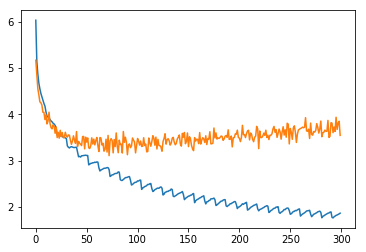

In [13]:
plt.plot(plot_losses_train)
plt.plot(plot_losses_test)
plt.show()

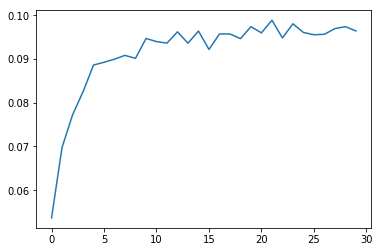

In [14]:
plt.plot(plot_bleu)
plt.show()

In [15]:
plot_bleu

[0.05366553402919899,
 0.0697769339014225,
 0.07721017258470125,
 0.08251491231727906,
 0.08863001115949729,
 0.08926253752787557,
 0.08997346862688665,
 0.09084590798483674,
 0.09015888322729226,
 0.09470092338672251,
 0.09400330336214206,
 0.093646927561693,
 0.09623092701619114,
 0.09362689533159671,
 0.09640861478479912,
 0.09219493456901509,
 0.09573878404895557,
 0.09573991966425574,
 0.0946662594154757,
 0.09740769262750067,
 0.09599013322476953,
 0.09887709925825405,
 0.09482747656314063,
 0.09806369238512148,
 0.09607933763137558,
 0.09556061309319466,
 0.09566711675471858,
 0.09696197061172272,
 0.09740625691747441,
 0.09643164125972727]